# POV DREAMING EXPERIMENTS

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# imports
import sys, os
sys.path.append('../../deep_dream_src/')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
from plot_utils import draw_smiles_linker, create_parity_plot
from nn_functions import featurize_df, prepare_hybrid_dataset, MolecularLSTMModel, prepare_dreaming_mof, prepare_dreaming_edge, split_dataframe
from utils import *
from tokenizer_functions import *
import selfies as sf
from group_selfies import GroupGrammar, bond_constraints
import math
import pickle 
group_constraints = {'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 3, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8, '*': math.inf, 'Fr': 1}
bond_constraints.set_semantic_constraints(group_constraints)
from dreaming_functions import *
import rdkit
rdkit.RDLogger.DisableLog('rdApp.warning')


### Collect input data

In [4]:
training_data = pd.read_csv('../../train_models/training_data.csv')
group_grammar = GroupGrammar.from_file('../gs_mof_grammar.txt')
training_data.head(1)

,edge_selfie,edge_canon_smile,edge_group_selfie,group_selfie_length,node_selfie,topo,SA_score,connection_point,MOFname,totalPOV_VF,...,GSA,henry_coefficient_CO2_300_mol_kg_Pa,log_henry_coefficient_CO2_300,heat_of_adsorption_CO2_300_kJ_mol,henry_coefficient_N2_300_mol_kg_Pa,log_henry_coefficient_N2_300,heat_of_adsorption_N2_300_kJ_mol,henry_CO2_N2_selectivity,log_CO2_N2_selectivity,filename
0,[O][O][C][=C][C][Branch1][C][Fr][C][Branch1][R...,OOC1=CC([Fr])C(OO)=CC1=C1NN([Fr])N1,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,28,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,acs,5.938156,"[11, 27]",acs_N125_edge1276,0.7545,...,4100.11,0.000005,-12.2,-10.097733,0.000002,-13.3,-4.43999,2.92,1.072161,acs_N125_edge1276.cif


In [5]:
target_names = ['totalPOV_VF']

mof_selfies_encoding, tokenized_info = featurize_df(
    training_data,
    target_names,
    edge_rep = 'edge_group_selfie',
    node_rep = 'node_selfie',
    topo_rep = 'topo'
    )

samples = 10000
split_by = {
    'method': 'sample',
    'train': samples,
    'validate': 1000,
    'test': 1000
    }

train_df, validate_df, test_df = split_dataframe(mof_selfies_encoding, split_by, seed=42)

../../deep_dream_src\nn_functions.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../../deep_dream_src\nn_functions.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../../deep_dream_src\nn_functions.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

# Load Language Models

In [6]:
dream_name = f'LSTM_interval_noise_06_{target_names[0]}_11000samples_group_selfies'
predictor_name = f'LSTM_interval_noise_00_{target_names[0]}_11000samples_group_selfies'

with open('../..//train_models/mof_saved_models/{}.pkl'.format(dream_name), 'rb') as f:
    dream_train_info = pickle.load(f)
scaler = dream_train_info['scaler']
tokenized_info = dream_train_info['tokenized_info']
dream_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
dream_hyperparams = dream_train_info['hyperparams']

with open('../../train_models/mof_saved_models/{}.pkl'.format(predictor_name), 'rb') as f:
    predictor_train_info = pickle.load(f)
predictor_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
predictor_hyperparams = predictor_train_info['hyperparams']
predictor_scaler = predictor_train_info['scaler']

c:\Users\x82753cc\AppData\Local\anaconda3\envs\deep_dreaming\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
dreaming_model = MolecularLSTMModel(**dream_hyperparams)
dreaming_model.load_state_dict(dream_train_info['model_state_dict'])
predictor_model = MolecularLSTMModel(**predictor_hyperparams)
predictor_model.load_state_dict(predictor_train_info['model_state_dict'])

<All keys matched successfully>

# Dreaming 

Get dreaming seed and set target value

In [11]:
seed_mof_string = '[Cl][C][C][Branch][C][Branch][FrH0][pop][Ring1][Ring1][pop][FrH0][.][O][=C][Branch1][C][Fr][O][Tb][O][C][Branch1][C][Fr][O][Tb][Branch1][=Branch2][O][C][Branch1][C][Fr][O][Ring1][Branch1][Branch1][=Branch2][O][C][Branch1][C][Fr][O][Ring1][=C][Branch1][#Branch2][O][C][Branch1][C][Fr][O][Ring2][Ring1][C][O][C][Branch1][C][Fr][O][Ring2][Ring1][=Branch1][&&][pcu]'
idx = train_df[train_df['mof_string']==seed_mof_string].index.item()
target_values = [1] # maximisation

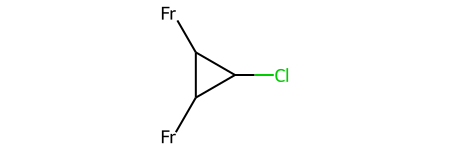

In [12]:
# What is the initial linker?
group_grammar.decoder(train_df.iloc[idx]['edge_group_selfie'])

Perform the optimisation

In [20]:
dream_settings = {
    'num_epochs': 5000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1,
    'patience': 50,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1
    }
valid_opt_pathway, transmutation_pathway, dreaming_losses = dream(
    dreaming_model,
    predictor_model,
    seed_mof_string,
    target_values,
    tokenized_info,
    group_grammar, 
    dream_settings
    )

torch.Size([1, 39, 73])
Restored variables from c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\deep_dreaming_MOFs\deep_dream_src\scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz
seed value: [0.51394695] | target value: [1.] | opt_flag: ['max']


opt flag: max, all targets: [0.74944997], valid linker, valid distance point
opt flag: max, all targets: [0.74944997], valid linker, invalid distance point
opt flag: max, all targets: [0.74944997], valid linker, invalid distance point
opt flag: max, all targets: [0.7788681], valid linker, valid distance point
opt flag: max, all targets: [0.7788681], valid linker, invalid distance point
opt flag: max, all targets: [0.7788681], valid linker, invalid distance point
opt flag: max, all targets: [0.7853006], valid linker, valid distance point
opt flag: max, all targets: [0.7853006], valid linker, invalid distance point
opt flag: max, all targets: [0.7853006], valid linker, invalid distance point
opt flag: max, all ta

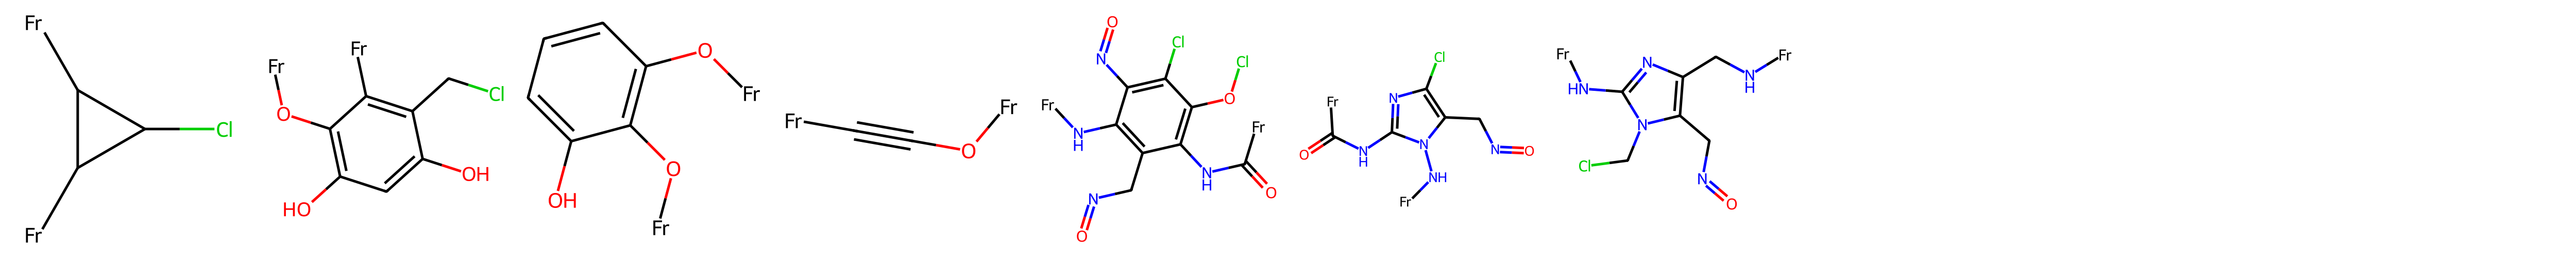

In [21]:
draw_smiles_linker(valid_opt_pathway['dreamed_smiles'],molsPerRow=10,subImgSize=(500,500),line_width=5)

We performed this optimisation 40 times using different seeds for random noise (i.e., 40 different optimisation outcomes, due to the stochastic nature of the model) 

In [8]:
import pickle

file_path = "./run_40_times/track_multiple_run.pkl"
with open(file_path, 'rb') as file:
    track_multiple_run = pickle.load(file)

In [9]:
dreamed_smiles = []
for opt_pathway in track_multiple_run:
    dreamed_smiles.append(opt_pathway.iloc[-1]['dreamed_smiles'])

In [12]:
from sklearn.manifold import TSNE
from utils import compute_fingerprints

# Generate fingerprints
seed_fps = compute_fingerprints([Chem.MolToSmiles(group_grammar.decoder(train_df.iloc[idx]['edge_group_selfie']))])
generated_fps = compute_fingerprints(dreamed_smiles)
reference_fps = compute_fingerprints(training_data['edge_canon_smile'].tolist())

# Combine fingerprints
all_fps = np.array(seed_fps + generated_fps + reference_fps)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=200, learning_rate=50, random_state=42)
reduced_data = tsne.fit_transform(all_fps)

# Split the transformed data for plotting
transformed_seed = reduced_data[:len(seed_fps), :]
transformed_generated = reduced_data[len(seed_fps):len(seed_fps)+len(generated_fps), :]
transformed_reference = reduced_data[len(seed_fps)+len(generated_fps):, :]


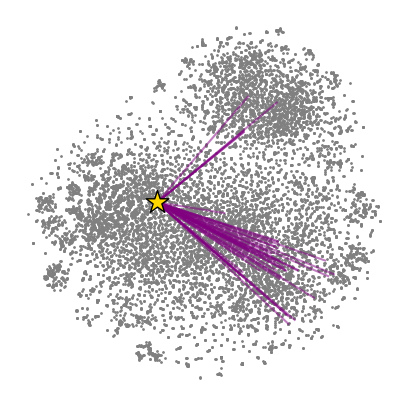

In [14]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(transformed_reference[:, 0], transformed_reference[:, 1], color='grey', s=1, label='Train linkers', zorder=-1)

for i in range(len(transformed_generated)):
    ax.plot([transformed_seed[0, 0], transformed_generated[i, 0]], [transformed_seed[0, 1], transformed_generated[i, 1]], color='purple', alpha=0.5, zorder=0)

ax.scatter(transformed_seed[:, 0], transformed_seed[:, 1], color='gold', marker='*', edgecolors='k', linewidths=1, s=300, label='Seed linker', zorder=1)

# Turn off box and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('tSNE.png',dpi=300,bbox_inches="tight")
plt.show()
